Roadmap:
- eseguire il cluster vero e proprio con k=20-25
- eseguire il cluster nuovamente tramite sklearn ed identificare eventuali differenza
- fare la join con il dateset iniziale
- rispondere alle domande aggiuntive


In [43]:
import pandas as pd
import numpy as np
import scipy

from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import k_means
from sklearn.cluster import KMeans as SK_KMeans
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Preprocessing

In [2]:
#...

In [2]:
df = pd.read_csv("./data/CleanDatabase.csv")

In [3]:
df = df.groupby('ProductId', as_index = False).agg({'Text': ' '.join})

In [4]:
df.head()

ProductId                                               Text
0  0006641040  days person say chicken soup probably go follo...
1  141278509X  product archer farm best drink mix ever mix fl...
2  2734888454  dog love chicken product china wont buy anymor...
3  2841233731  book easy read ingredients available store rec...
4  7310172001  product health snack pup make beef liver puppy...

# Tf-Idf Vectorizer

In [5]:
tf_idf = TfidfVectorizer(max_features=30000, stop_words='english', use_idf=True).fit_transform(df["Text"])

In [6]:
var_tfidf = 0
for i in range(tf_idf.shape[0]):
    var_tfidf += np.var(tf_idf[i].todense())
var_tfidf

2.4718108140800035

# TruncatedSVD

In [36]:
def best_compenents(tf_idf, n_components_initial, n_components_final, goal):
    variance_init = 0
    k = n_components_initial
    max_k = np.INF
    
    while n_components_initial <= k < n_components_final:
        svd = TruncatedSVD(n_components=k)
        svd.fit(tf_idf)
        
        variance = float(np.sum(svd.explained_variance_ratio_)*100)
        print(variance, k)
        
        if goal < variance < goal + 1:
            break
            
        if variance < goal:
            if k*2 > max_k:
                k += max_k
                k = k >> 1
            else:
                k *= 2
        else:
            k = k >> 2
            k *= 3 
            
    return k

In [7]:
n_best_components = 950 # best_compenents(tf_idf, 100, 10000, 60)
svd = TruncatedSVD(n_components=n_best_components)
X = svd.fit_transform(tf_idf)

In [9]:
X.shape, X

((74258, 950),
 array([[ 1.94887531e-01, -5.87168357e-02, -1.90294924e-02, ...,
          1.40779586e-02,  3.25757421e-02, -5.86725016e-03],
        [ 1.48120329e-01, -1.05293931e-02, -6.57476472e-06, ...,
          9.17394958e-03,  7.35322890e-03, -3.04100942e-04],
        [ 1.51334423e-01, -1.09013685e-01, -1.33395812e-01, ...,
         -1.61290657e-02,  1.00792057e-02, -1.72006200e-02],
        ...,
        [ 4.43693016e-02, -3.87353410e-03,  3.06819785e-03, ...,
          1.06278796e-02,  5.39511393e-03, -7.22674864e-03],
        [ 1.39601812e-01, -4.33366834e-02, -9.32850779e-03, ...,
         -2.21896071e-02,  8.33944500e-03,  1.76864751e-02],
        [ 1.13108080e-01, -3.50728109e-02, -1.06110823e-03, ...,
         -1.85487919e-02,  5.06883931e-03,  8.95991043e-03]]))

In [40]:
# np.savetxt("./data/X.txt", X)

# KMeans
#### K-Means Clustering 
1. Choose the number of clusters(K) and obtain the data points 
2. Place the centroids c_1, c_2, ..... c_k randomly 
3. Repeat steps 4 and 5 until convergence or until the end of a fixed number of iterations
4. for each data point x_i:
       - find the nearest centroid(c_1, c_2 .. c_k) 
       - assign the point to that cluster 
5. for each cluster j = 1..k
       - new centroid = mean of all points assigned to that cluster
6. End

In [14]:
class KMeans:
    def __init__(self, K, n_features, random_state=None):
        if random_state:
            np.random.seed(seed=random_state)
        self.K = K
        self.f = n_features
        self.centroids = np.random.rand(K, n_features) - 0.5 # Value between -0.50 <= x < 0.50
        
    def fit(self, X, max_iter = 300, plot_cluster_evolution=False):
        self.centroids *= np.mean(X)
        X_size = X.shape[0]
        U_old = np.zeros(X_size)
        U = np.zeros(X_size)
        inertia_values = []
        changes_values = []
        
        for i in range(max_iter):
            U_old = np.copy(U)
            U, inertia = self.predict(X, inertia=True)
            n_changes = np.sum(U != U_old)
            for j in range(self.K):
                filt = U == j
                if filt.any():
                    self.centroids[j] = np.mean(X[filt], axis=0)
            
            print('Iter:', i, 'Inerzia:', inertia, 'N. Changes:', n_changes)
            
            if plot_cluster_evolution:
                inertia_values.append(inertia)
                changes_values.append(n_changes)
            
            if (U == U_old).all(): # Converge
                break
            
        
        if plot_cluster_evolution:
            inertia_values = np.array(inertia_values)
            changes_values = np.array(changes_values)
            # Plot Inertia
            plt.figure(figsize=(16,7))
            plt.ylabel('Inertia', size=22)
            sns.lineplot(data=inertia_values)
            plt.xlabel('N. Iteration', size=20)
            plt.xticks(np.arange(inertia_values.shape[0]), np.arange(inertia_values.shape[0])+1)
            plt.show()
            # Plot n. changes
            plt.figure(figsize=(16,7))
            plt.ylabel('N. Changes', size=22)
            sns.lineplot(data=changes_values)
            plt.xlabel('N. Iteration', size=20)
            plt.xticks(np.arange(changes_values.shape[0]), np.arange(changes_values.shape[0])+1)
            plt.show()
        
        return inertia
    
    def calc_inertia(self, X):
        return self.predict(X, inertia=True)[1]
    
    def predict(self, X, inertia=False):
        n = X.shape[0]
        
        # Calculate the distances between each sample and each centroid
        dist = np.zeros((n, self.K))
        for i in range(n):
            for j in range(self.K):
                dist[i,j] = scipy.spatial.distance.euclidean(X[i], self.centroids[j])
        
        # Calculate, for each sample, the nearest centroid
        res = np.argmin(dist, axis=1)
        
        if inertia:
            # Calculate the inertia
            _inertia = np.sum(np.take_along_axis(dist, np.expand_dims(res, axis=-1), axis=-1))
            return res, _inertia
        
        return res

In [10]:
K = 12
max_iter = 300
#our_kMeans = KMeans(K, n_best_components)
sk_kMeans = SK_KMeans(n_clusters=K, max_iter=max_iter)

In [9]:
#our_inertia = our_kMeans.fit(X, max_iter=max_iter)
sk_kMeans.fit(X)
# sk_inertia = k_means(X, K, max_iter=max_iter, verbose=True)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [18]:
_, our_inertia = our_kMeans.predict(X, True)

In [80]:
sk_prediction = sk_kMeans.predict(X)

In [82]:
np.unique(sk_prediction, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([  441,   864,  1505, 32746,  3915,  1100, 10135,  2431,  1773,
         2366,   895,  3886,  2497,   712,   229,  3415,  2004,  1758,
          456,  1130], dtype=int64))

In [17]:
our_inertia

True

In [ ]:
our_inertia, sk_inertia

In [27]:
_X = X[:]
_X.shape

(74258, 950)

In [120]:
#l = range(4, 61, 7) # [4,11,18,25,32,39,46,53,60]
l = range(6, 61, 6) # [4,11,18,25,32]

In [32]:
l2 = [5,10,15,20,25,30,40,50,70]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [48:39<00:00, 291.97s/it]


KeyError: 25

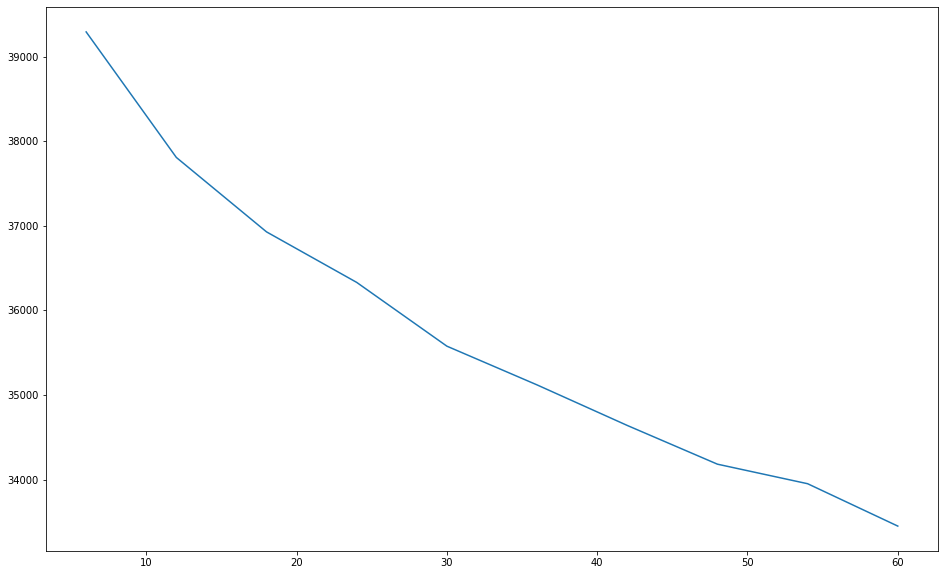

In [121]:
elbow = {}
for k in tqdm(l):
    elbow_model = SK_KMeans(n_clusters=k)
    elbow_model.fit_predict(X)
    elbow[k] = elbow_model.inertia_ # inertia = sum of squared distances of samples to their closest cluster center
    
# for k in tqdm(range(50, 201, 25)):
#     elbow_model = SK_KMeans(n_clusters=k)
#     elbow_model.fit_predict(_X)
#     elbow[k] = elbow_model.inertia_ # inertia = sum of squared distances of samples to their closest cluster center

plt.figure(figsize=(16,10))
plt.plot(list(elbow.keys()), list(elbow.values()))
plt.annotate('Cluster Size', xy=(25, elbow[25]), xytext=(30,38000), arrowprops=dict(facecolor='black', shrink=0.05))

In [33]:
elbow_2 = {}
for k in tqdm(l2):
    elbow_model = SK_KMeans(n_clusters=k)
    elbow_model.fit_predict(X)
    elbow_2[k] = elbow_model.inertia_ # inertia = sum of squared distances of samples to their closest cluster center

plt.figure(figsize=(16,10))
plt.plot(list(elbow_2.keys()), list(elbow_2.values()))
plt.annotate('Cluster Size', xy=(25, elbow[25]), xytext=(30,38000), arrowprops=dict(facecolor='black', shrink=0.05))

  0%|                                                                                            | 0/9 [01:53<?, ?it/s]


KeyboardInterrupt: 

In [54]:
X

array([[ 1.94887531e-01, -5.87168357e-02, -1.90294925e-02, ...,
        -2.02419821e-02, -3.34133749e-02,  1.06753814e-03],
       [ 1.48120329e-01, -1.05293931e-02, -6.57477170e-06, ...,
        -1.26133500e-02,  8.01371409e-03,  1.03209963e-02],
       [ 1.51334423e-01, -1.09013685e-01, -1.33395812e-01, ...,
         1.58058832e-02, -1.51202133e-02,  7.94128817e-03],
       ...,
       [ 4.43693016e-02, -3.87353410e-03,  3.06819785e-03, ...,
         4.43489258e-03, -7.73628257e-03,  1.68864628e-02],
       [ 1.39601812e-01, -4.33366834e-02, -9.32850777e-03, ...,
         3.13507848e-02,  1.51967052e-03, -4.14573539e-02],
       [ 1.13108080e-01, -3.50728109e-02, -1.06110823e-03, ...,
         1.15547431e-02,  3.02739752e-03,  5.66844116e-03]])

In [34]:
elbow # old

{2: 41751.43134483724,
 4: 40329.381990624475,
 6: 39570.10930757552,
 8: 38584.125634933655,
 10: 38243.23251313096,
 12: 37919.936974100594,
 15: 37457.5397798227,
 17: 37159.64518375467,
 20: 36673.78676427781,
 23: 36284.27161604379,
 27: 35810.771976734286,
 31: 35502.317411071366,
 38: 34864.89631815433,
 45: 34426.79435320746,
 52: 33972.02166589827,
 60: 33455.50078864582,
 75: 32774.2817165911,
 90: 32191.979546429324,
 110: 31467.504530706166,
 150: 30441.23201402301,
 200: 29430.678709622152}

In [122]:
elbow

{6: 39292.12093903771,
 12: 37808.50587658412,
 18: 36928.92702088058,
 24: 36331.79123649087,
 30: 35578.0970241767,
 36: 35120.30657915485,
 42: 34641.23776333877,
 48: 34183.43402540756,
 54: 33952.54268094326,
 60: 33451.70566320363}

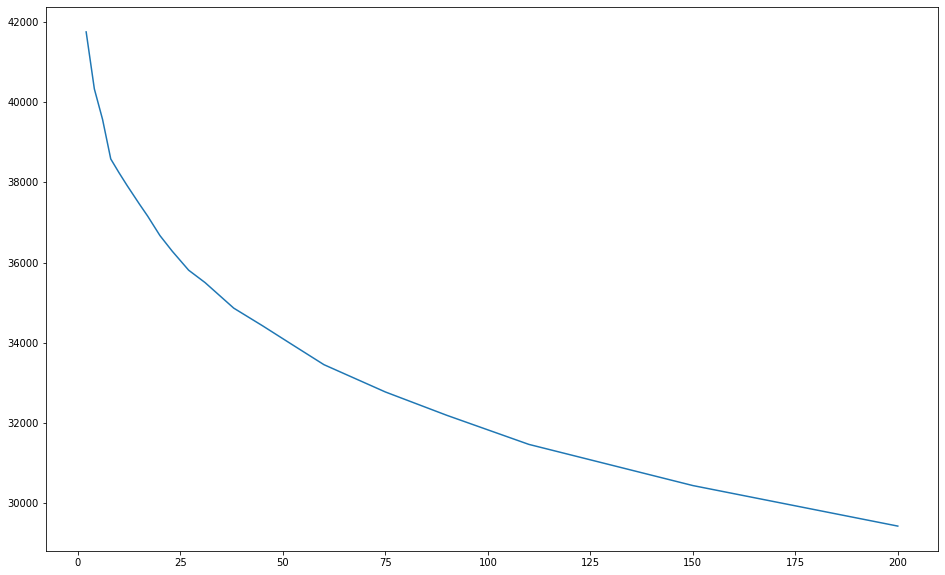

In [36]:
plt.figure(figsize=(16,10))
plt.plot(list(elbow.keys()), list(elbow.values()))

Text(30, 38000, 'Cluster Size')

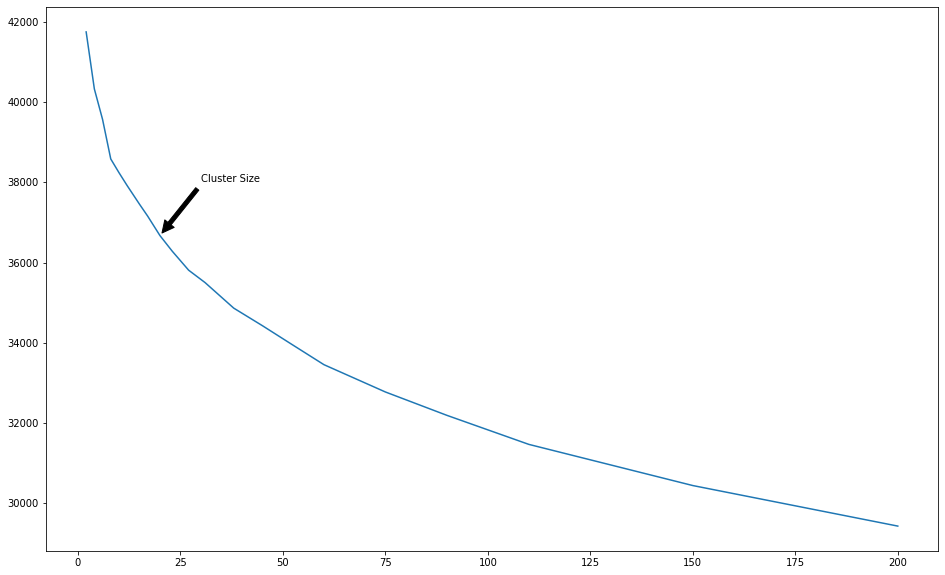

In [39]:
plt.figure(figsize=(16,10))
plt.plot(list(elbow.keys()), list(elbow.values()))
plt.annotate('Cluster Size', xy=(20, elbow[20]), xytext=(30,38000), arrowprops=dict(facecolor='black', shrink=0.05))

In [15]:
# %%time
model = KMeans(K, n_best_components)

In [87]:
X

array([[ 1.94887531e-01, -5.87168357e-02, -1.90294925e-02, ...,
        -2.02419821e-02, -3.34133749e-02,  1.06753814e-03],
       [ 1.48120329e-01, -1.05293931e-02, -6.57477170e-06, ...,
        -1.26133500e-02,  8.01371409e-03,  1.03209963e-02],
       [ 1.51334423e-01, -1.09013685e-01, -1.33395812e-01, ...,
         1.58058832e-02, -1.51202133e-02,  7.94128817e-03],
       ...,
       [ 4.43693016e-02, -3.87353410e-03,  3.06819785e-03, ...,
         4.43489258e-03, -7.73628257e-03,  1.68864628e-02],
       [ 1.39601812e-01, -4.33366834e-02, -9.32850777e-03, ...,
         3.13507848e-02,  1.51967052e-03, -4.14573539e-02],
       [ 1.13108080e-01, -3.50728109e-02, -1.06110823e-03, ...,
         1.15547431e-02,  3.02739752e-03,  5.66844116e-03]])

In [16]:
our_inertia = model.fit(X)

Iter: 0 Inerzia: 57516.19666333063 N. Changes: 72146
Iter: 1 Inerzia: 54524.90261932017 N. Changes: 51764
Iter: 2 Inerzia: 52579.72320940538 N. Changes: 27710
Iter: 3 Inerzia: 51880.648679905906 N. Changes: 13933
Iter: 4 Inerzia: 51614.71444674857 N. Changes: 7739
Iter: 5 Inerzia: 51529.214301949636 N. Changes: 5214
Iter: 6 Inerzia: 51485.32326504639 N. Changes: 3904
Iter: 7 Inerzia: 51458.78299207638 N. Changes: 2706
Iter: 8 Inerzia: 51443.53426517414 N. Changes: 1959
Iter: 9 Inerzia: 51431.5231908352 N. Changes: 1506
Iter: 10 Inerzia: 51417.885950368036 N. Changes: 1209
Iter: 11 Inerzia: 51412.53604399148 N. Changes: 1092
Iter: 12 Inerzia: 51400.47883695947 N. Changes: 1069
Iter: 13 Inerzia: 51377.824039732586 N. Changes: 807
Iter: 14 Inerzia: 51375.13505551083 N. Changes: 779
Iter: 15 Inerzia: 51373.10520249018 N. Changes: 779
Iter: 16 Inerzia: 51369.82544090162 N. Changes: 954
Iter: 17 Inerzia: 51364.17011180241 N. Changes: 1111
Iter: 18 Inerzia: 51356.60016391801 N. Changes: 1249


KeyboardInterrupt: 

In [17]:
%%time
pred, our_inertia = model.predict(X, True)

Wall time: 24.3 s


In [18]:
np.unique(pred, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int64),
 array([ 3087,  3096,  1347, 25588,   917,   846,   718,  4867,  1269,
         6247,  3460,  1069,  3906,  1760,  6205,  2151,  2400,  1034,
         2445,  1846], dtype=int64))

* creiamo i cluster
* groupby sui cluster
* join sui text
* countVect per ogni cluster
* stampiamo la wordcloud e poi faccia le considerazioni


In [19]:
#df['Cluster'] = model.predict(X)
df['Cluster'] = pred

In [20]:
df

ProductId                                               Text  Cluster
0      0006641040  days person say chicken soup probably go follo...       11
1      141278509X  product archer farm best drink mix ever mix fl...       10
2      2734888454  dog love chicken product china wont buy anymor...       12
3      2841233731  book easy read ingredients available store rec...        3
4      7310172001  product health snack pup make beef liver puppy...       12
...           ...                                                ...      ...
74253  B009UOFTUI  coffee supposedly premium taste watery thin go...       18
74254  B009UOFU20  coffee supposedly premium taste watery thin go...       18
74255  B009UUS05I  basket perfect sympathy gift try express much ...        3
74256  B009WSNWC4  purchase product local store ny kid love quick...        3
74257  B009WVB40S  purchase send son away college deliver right d...        3

[74258 rows x 3 columns]

In [21]:
product_cluster = df.set_index('ProductId')['Cluster']

In [22]:
reviews = pd.read_csv('./data/Reviews.csv')

In [23]:
rev_complete = reviews.join(product_cluster, on='ProductId')

In [25]:
# risposta alla 2.3.2
df.groupby('Cluster').size()

Cluster
0      3087
1      3096
2      1347
3     25588
4       917
5       846
6       718
7      4867
8      1269
9      6247
10     3460
11     1069
12     3906
13     1760
14     6205
15     2151
16     2400
17     1034
18     2445
19     1846
dtype: int64

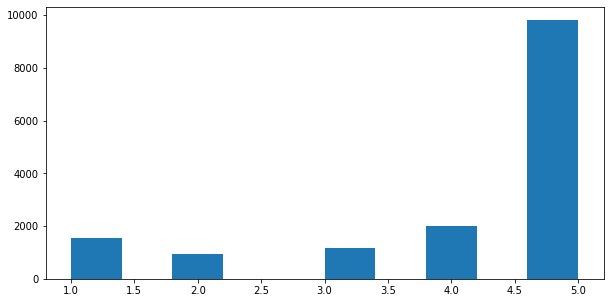

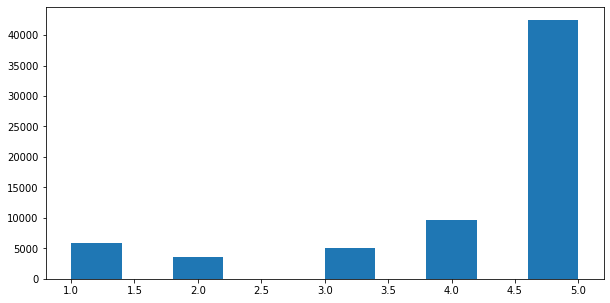

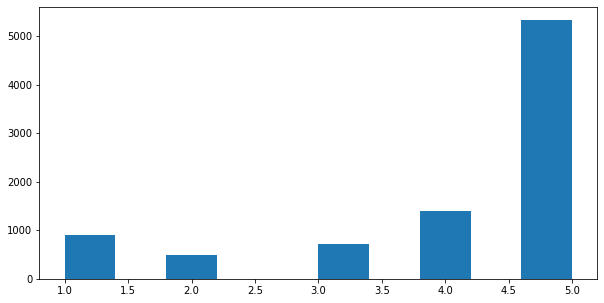

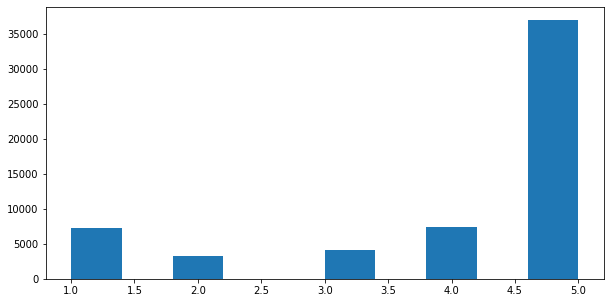

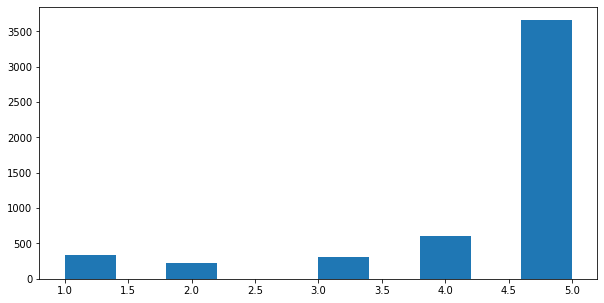

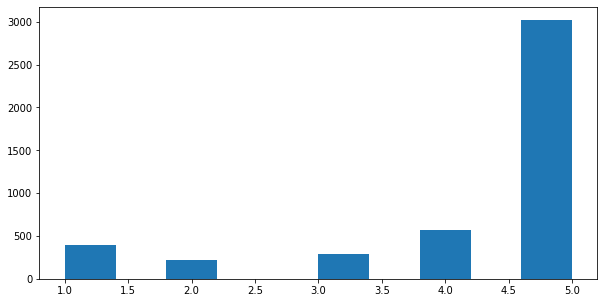

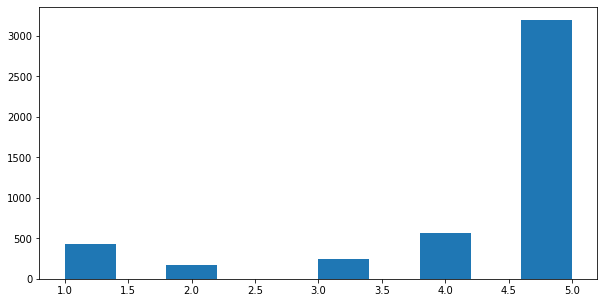

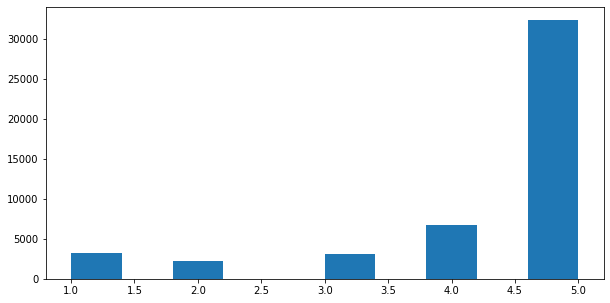

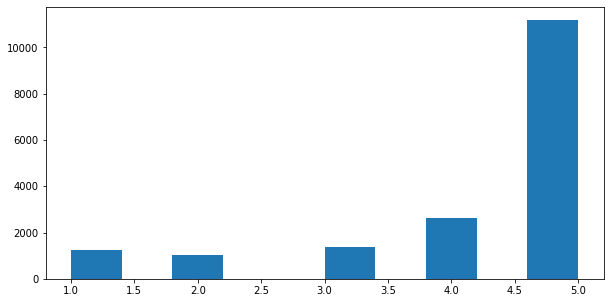

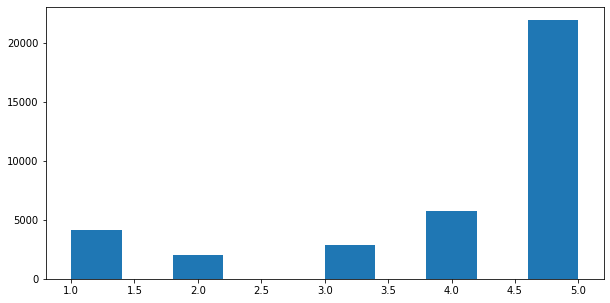

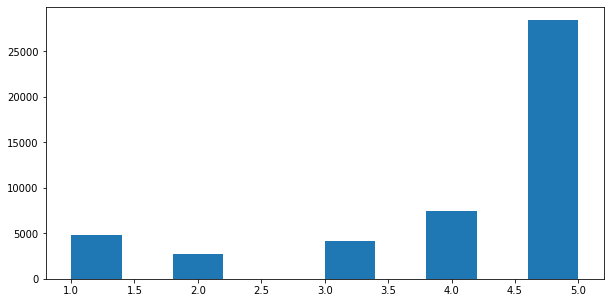

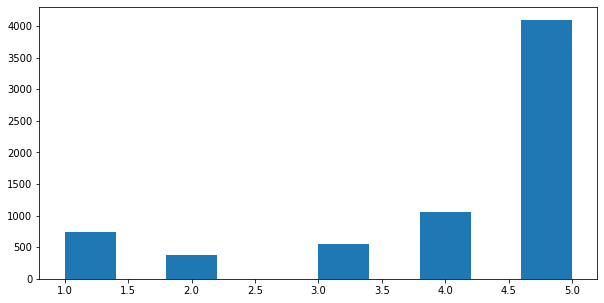

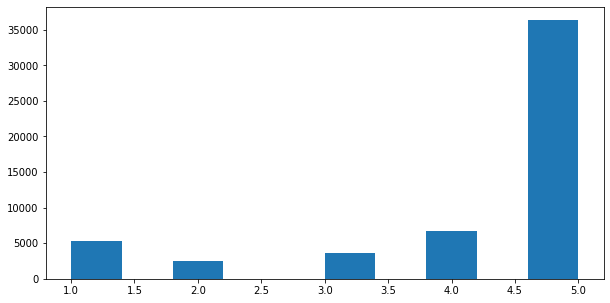

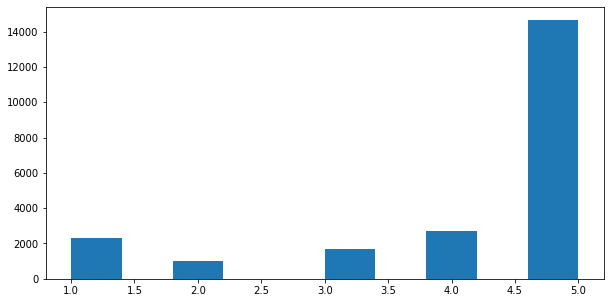

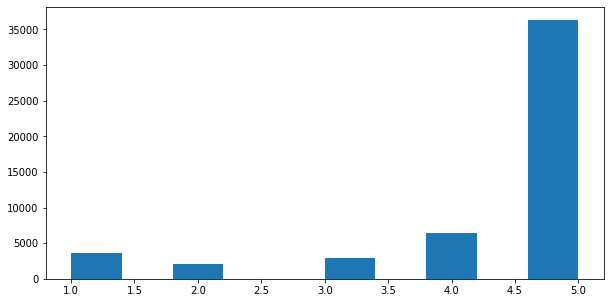

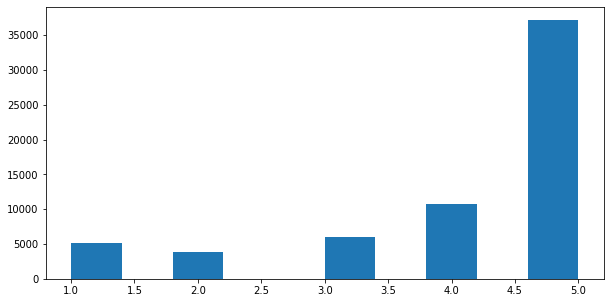

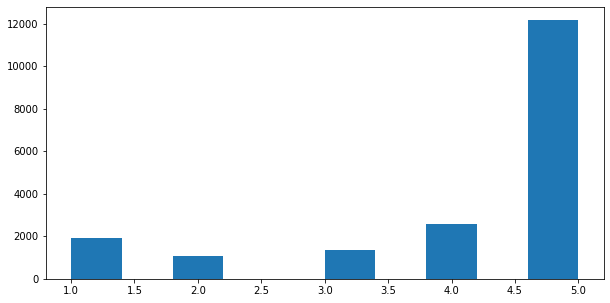

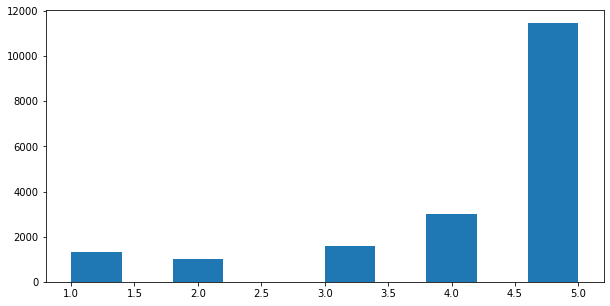

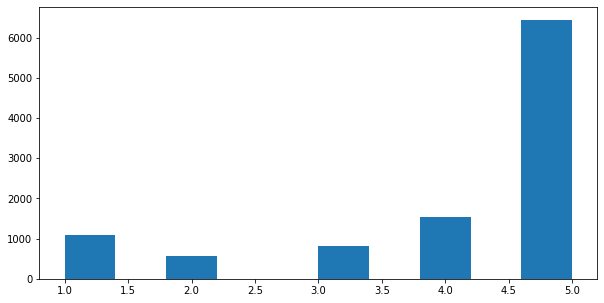

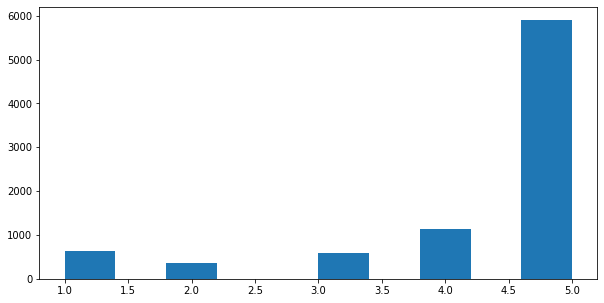

In [26]:
# 2.3.3

#score = rev_complete.groupby('Cluster', as_index = False)
#sns.histplot(data=score, x='Score')

for cluster in range(K):
    fig = plt.figure(figsize=(10,5))
    plt.hist(rev_complete[rev_complete.Cluster == cluster].Score)
    plt.show()



In [27]:
# 2.3.4
rev_complete.groupby('Cluster').UserId.nunique()

Cluster
0     12729
1     26600
2      7128
3     47608
4      3377
5      3453
6      3962
7     24529
8      7976
9     26258
10    28430
11     5449
12    21080
13     8811
14    36982
15    27115
16    12785
17     9198
18     9039
19     6954
Name: UserId, dtype: int64

In [35]:
cluster_text = df.groupby('Cluster').agg({'Text': ' '.join})

In [42]:
cluster_text

Text
Cluster                                                   
0        dentist see many patients dry mouth result med...
1        ever freeze dry ice cream stuff size treat lar...
2        hard find raw milk unpasteurized cheese great ...
3        book easy read ingredients available store rec...
4        distinct aroma yet bring original flavor foods...
5        coffee bean discribed good quality think get h...
6        randomly buy grocery store day absolutely love...
7        purchase product recently teenaged son recur a...
8        come huge tin much bigger expect cookies sweet...
9        product available br http br br victor trap un...
10       product archer farm best drink mix ever mix fl...
11       days person say chicken soup probably go follo...
12       dog love chicken product china wont buy anymor...
13       speak owners cat really love food reason give ...
14       search amazon use organic food color list amaz...
15       things like point p quot espresso quot roast d...
16       start seed indoors early march harden front po...
17       reviewer state high fructose corn syrup wrong ...
18       use briel chamonix machine purchase amazon pro...
19       stuff rock egg chili highly recomended provide...

In [88]:
from nltk.corpus import words
wordlist = words.words()

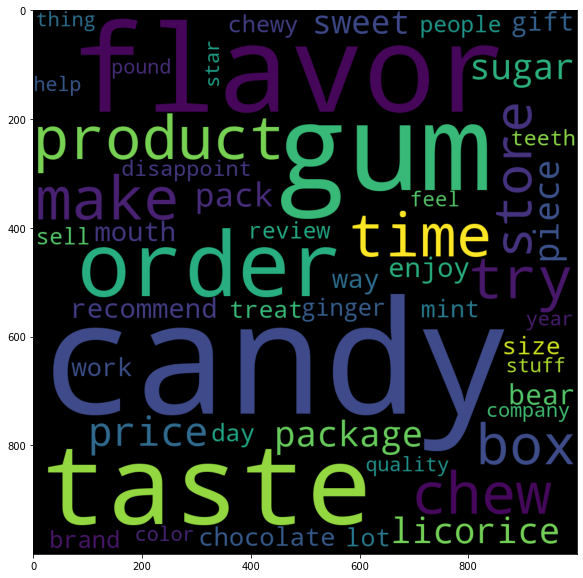

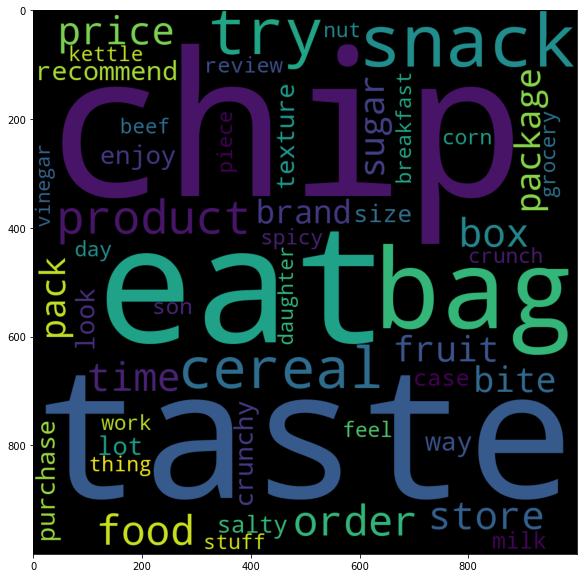

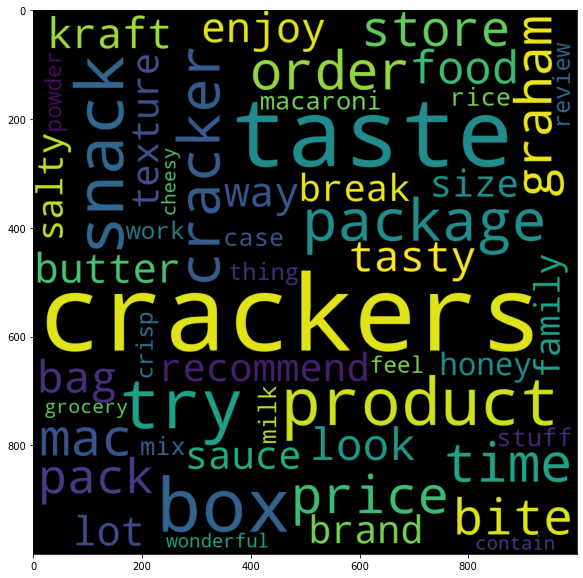

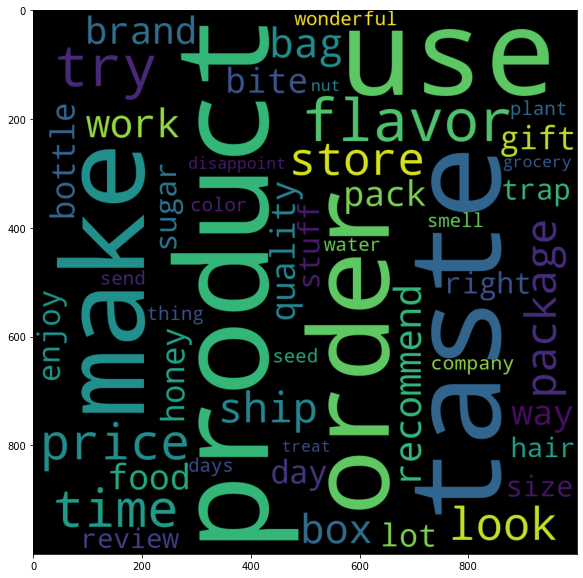

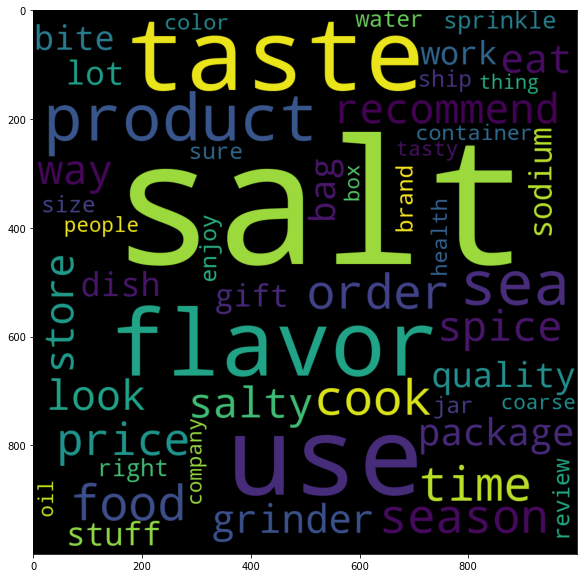

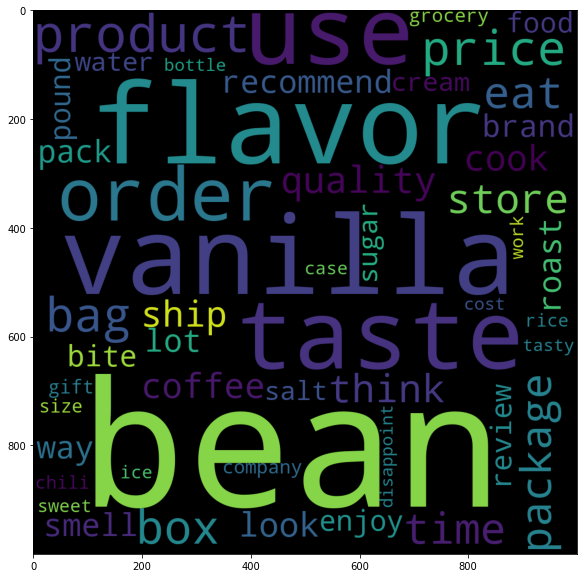

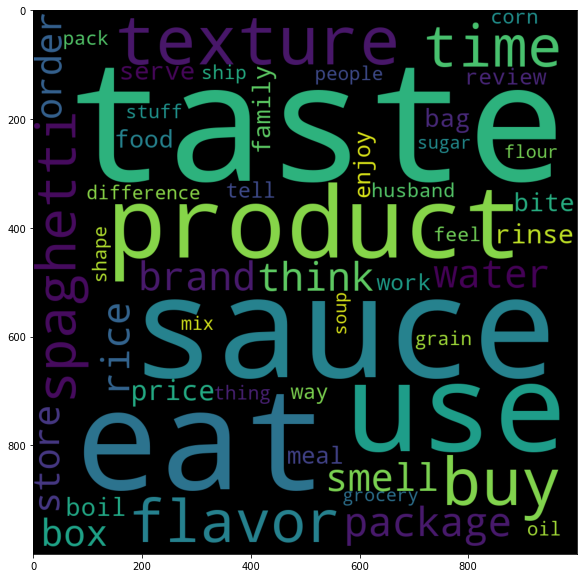

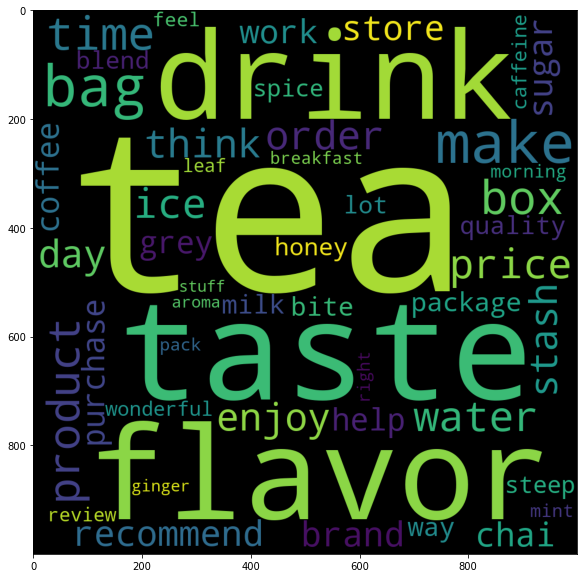

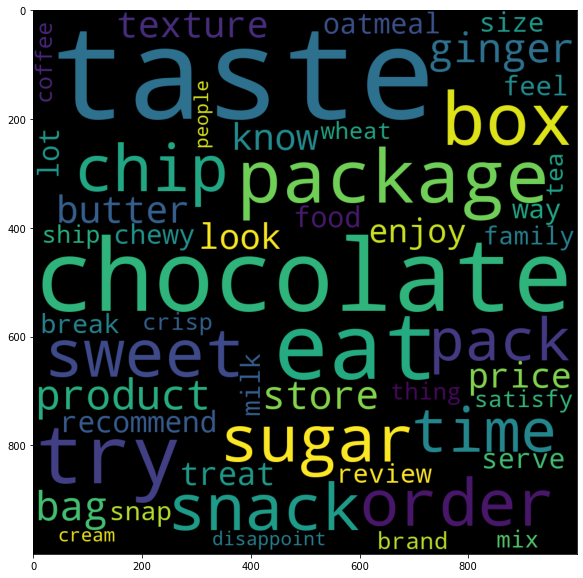

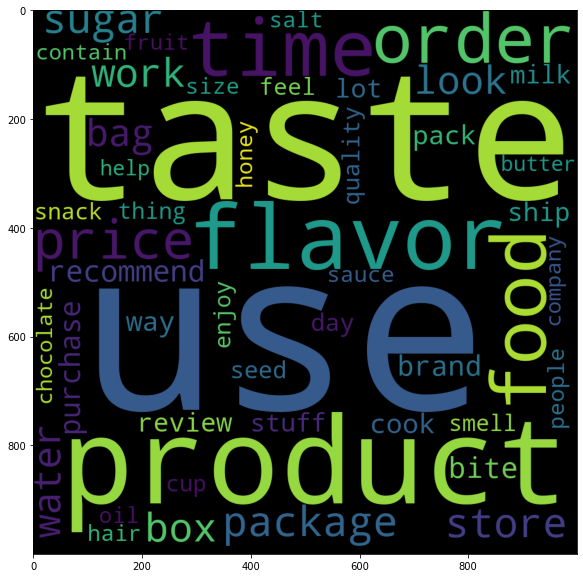

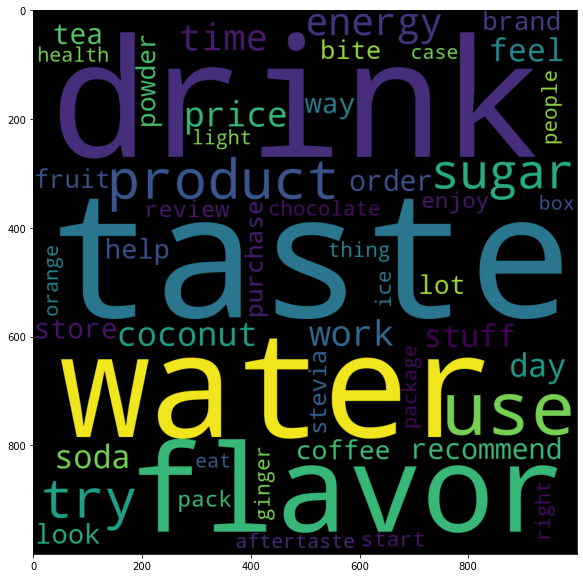

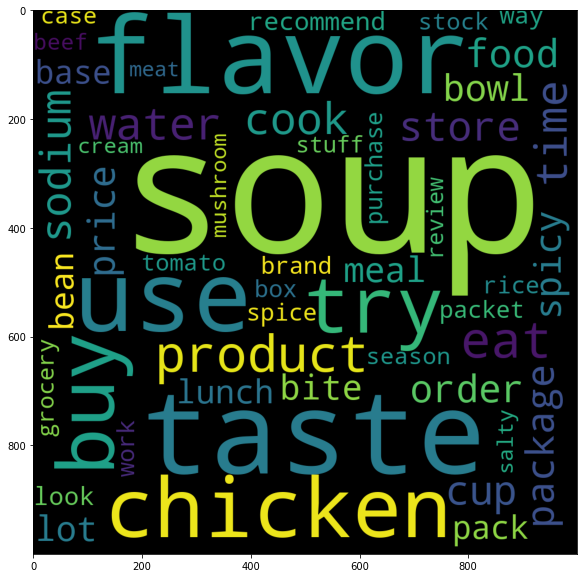

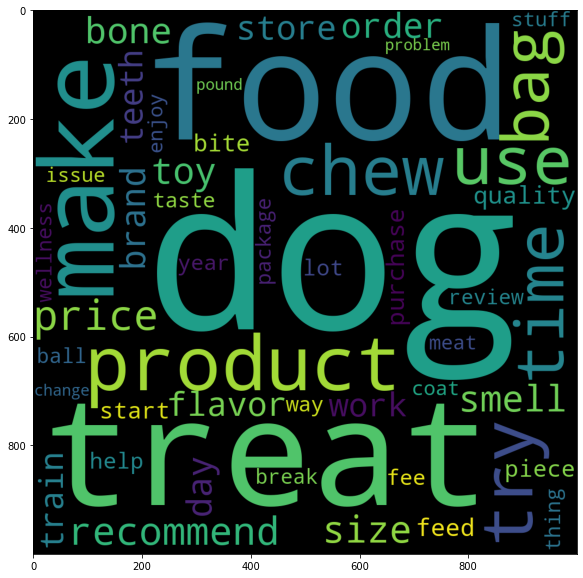

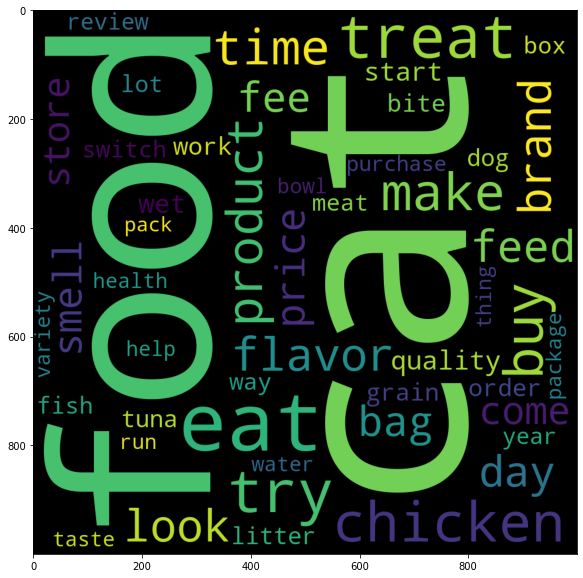

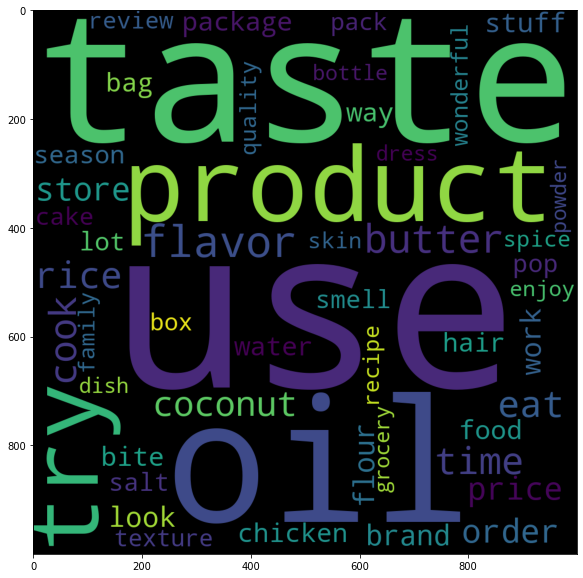

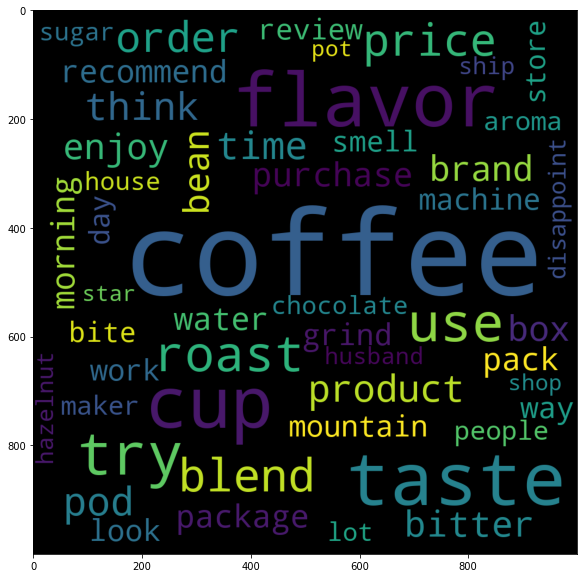

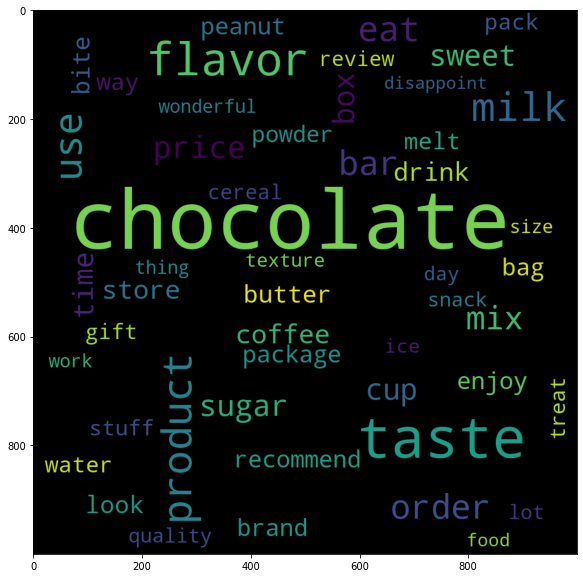

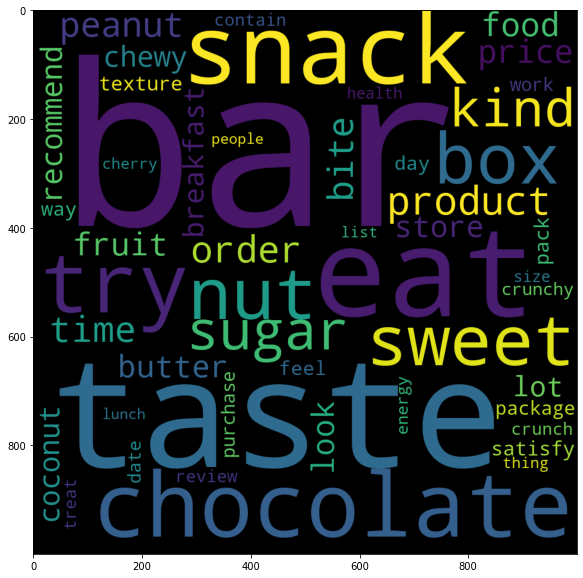

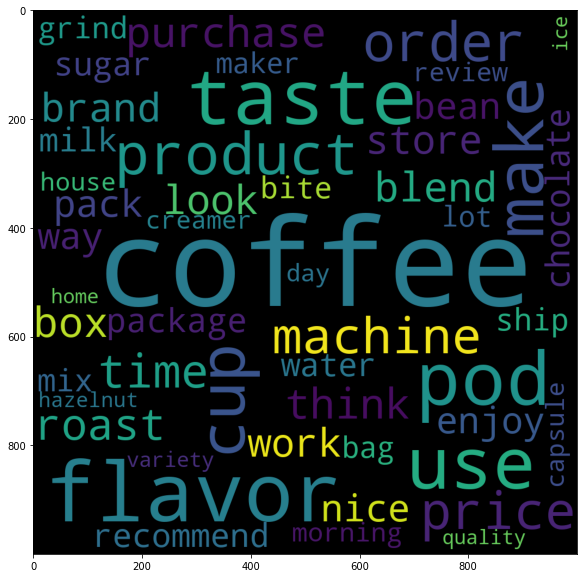

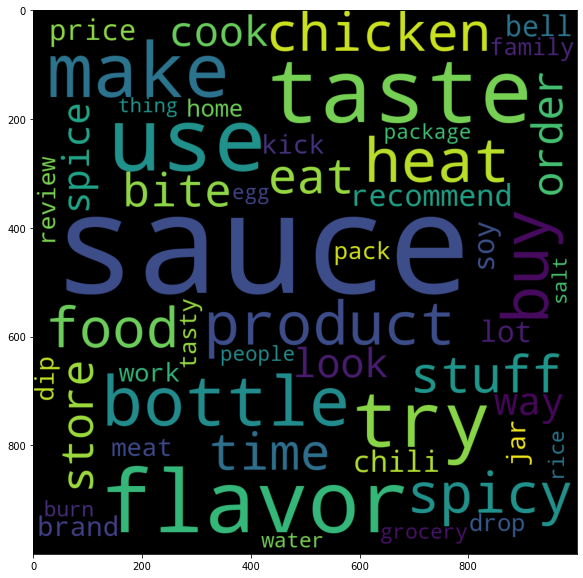

In [119]:
for i in range(K):
    txt = cluster_text.loc[i].Text
    
    # Count the words in the text
    cv = CountVectorizer(min_df=0, stop_words="english", max_features=200)
    counts = cv.fit_transform([txt]).toarray().ravel()
    words = np.array(cv.get_feature_names())
    
    # Filter the words
    tag = np.array(pos_tag(words))[:,1]
    acceptable_word = [True if word in wordlist else False for word in words]
    word_filter = np.logical_and(np.logical_or(tag == 'NN', tag == 'NNS'), acceptable_word)
    
    # Find the top n_top most frequent words in the text
    n_top = 50
    top_word = np.array(words)[np.argsort(counts*word_filter)[-n_top:]].tolist()
    top_count = counts[np.argsort(counts*word_filter)[-n_top:]].tolist()
    word_freq= dict(zip(top_word, top_count))
    
    # Plot the wordcloud
    plt.figure(figsize=(10,10))
    wc = WordCloud(width=1000,height=1000).generate_from_frequencies(word_freq)
    plt.imshow(wc)